<a href="https://colab.research.google.com/github/athabrani/DeepLearning/blob/main/Tensoflow_SVHN_YES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import scipy.io
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'svhn_cropped',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/incomplete.6NBTS6_3.1.0/svhn_cropped-train.tfrecord*...:   0%…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/incomplete.6NBTS6_3.1.0/svhn_cropped-test.tfrecord*...:   0%|…

Generating extra examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/incomplete.6NBTS6_3.1.0/svhn_cropped-extra.tfrecord*...:   0%…

Dataset svhn_cropped downloaded and prepared to /root/tensorflow_datasets/svhn_cropped/3.1.0. Subsequent calls will reuse this data.


In [ ]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    mean = tf.constant([0.4377, 0.4438, 0.4728])
    std = tf.constant([0.1980, 0.2010, 0.1970])
    image = (image - mean) / std
    return image, label

BATCH_SIZE = 128
ds_train = ds_train.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


#CNN Model

In [ ]:
def build_cnn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')  # 10 digits
    ])
    return model

In [ ]:
def compile_model(model):
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


def evaluate_model(model, dataset, output_size=10, model_name="Model"):
    y_true, y_pred, y_prob = [], [], []

    for images, labels in dataset:
        outputs = model(images, training=False)
        probs = tf.nn.softmax(outputs).numpy()
        preds = tf.argmax(probs, axis=1).numpy()

        y_true.extend(labels.numpy())
        y_pred.extend(preds)
        y_prob.extend(probs)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    # Metrik evaluasi
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    auc_score = roc_auc_score(tf.one_hot(y_true, output_size).numpy(), y_prob, average='macro', multi_class='ovr')

    print(f"\n Evaluation Metrics for {model_name}")
    print("-" * 40)
    print(f"Accuracy  : {acc * 100:.2f}%")
    print(f"Precision : {precision : .4f}")
    print(f"Recall    : {recall : .4f}")
    print(f"F1 Score  : {f1 : .4f}")
    print(f"AUC Score : {auc_score : .4f}")

    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # ROC Curve per class
    plt.figure(figsize=(10, 8))
    y_true_bin = tf.one_hot(y_true, output_size).numpy()

    for i in range(output_size):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        auc_i = roc_auc_score(y_true_bin[:, i], y_prob[:, i])
        plt.plot(fpr, tpr, label=f'Class {i} (AUC={auc_i:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title(f"ROC Curve - {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
cnn_model = compile_model(build_cnn_model())
print("\n=== Training CNN Model ===")
cnn_model.fit(ds_train, epochs=10, validation_data=ds_test)


=== Training CNN Model ===
Epoch 1/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 115s 198ms/step - accuracy: 0.6355 - loss: 1.1412 - val_accuracy: 0.8508 - val_loss: 0.5533
Epoch 2/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 140s 194ms/step - accuracy: 0.8717 - loss: 0.4633 - val_accuracy: 0.8675 - val_loss: 0.4782
Epoch 3/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 112s 195ms/step - accuracy: 0.8974 - loss: 0.3663 - val_accuracy: 0.8753 - val_loss: 0.4450
Epoch 4/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 142s 194ms/step - accuracy: 0.9127 - loss: 0.3093 - val_accuracy: 0.8821 - val_loss: 0.4289
Epoch 5/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 118s 205ms/step - accuracy: 0.9257 - loss: 0.2646 - val_accuracy: 0.8824 - val_loss: 0.4429
Epoch 6/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 117s 205ms/step - accuracy: 0.9361 - loss: 0.2280 - val_accuracy: 0.8836 - val_loss: 0.4673
Epoch 7/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 114s 199ms/step - accuracy: 0.9462 - loss: 0.1943 - val_accuracy: 0.8834 - val_loss: 0.5006
Epoch 8/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 112s 196

CNN Evaluation:

 Evaluation Metrics for CNN
----------------------------------------
Accuracy  : 88.35%
Precision :  0.8701
Recall    :  0.8774
F1 Score  :  0.8723
AUC Score :  0.9838


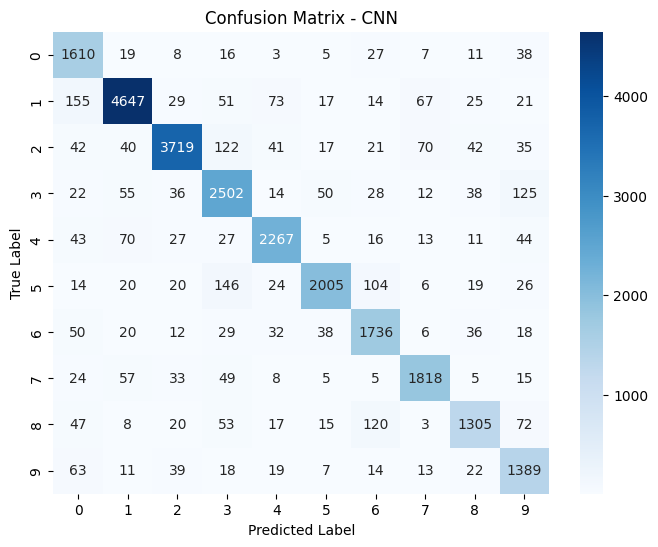

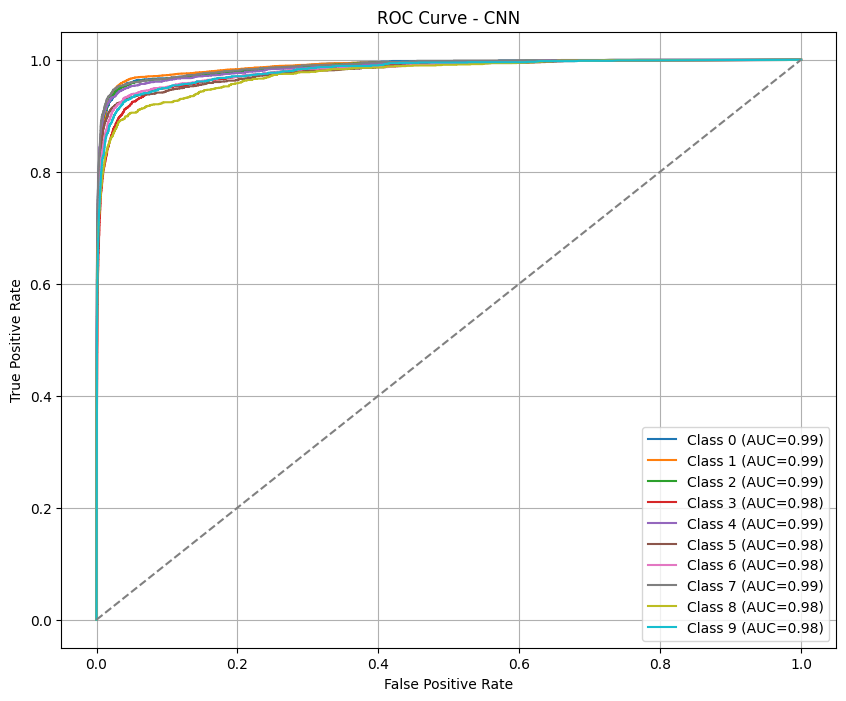

In [ ]:
print("CNN Evaluation:")
evaluate_model(cnn_model, ds_test, output_size=10, model_name="CNN")

#MLP Model

In [ ]:
def build_mlp_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

def compile_mlp_model(model):
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
def evaluate_mlp_model(model, dataset, output_size=10, model_name="Model"):
    y_true, y_pred, y_prob = [], [], []

    for images, labels in dataset:
        outputs = model(images, training=False)
        probs = tf.nn.softmax(outputs).numpy()
        preds = tf.argmax(probs, axis=1).numpy()

        y_true.extend(labels.numpy())
        y_pred.extend(preds)
        y_prob.extend(probs)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    # Metrik evaluasi
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    auc_score = roc_auc_score(tf.one_hot(y_true, output_size).numpy(), y_prob, average='macro', multi_class='ovr')

    print(f"\n Evaluation Metrics for {model_name}")
    print("-" * 40)
    print(f"Accuracy  : {acc * 100:.2f}%")
    print(f"Precision : {precision : .4f}")
    print(f"Recall    : {recall : .4f}")
    print(f"F1 Score  : {f1 : .4f}")
    print(f"AUC Score : {auc_score : .4f}")

    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # ROC Curve per class
    plt.figure(figsize=(10, 8))
    y_true_bin = tf.one_hot(y_true, output_size).numpy()

    for i in range(output_size):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        auc_i = roc_auc_score(y_true_bin[:, i], y_prob[:, i])
        plt.plot(fpr, tpr, label=f'Class {i} (AUC={auc_i:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title(f"ROC Curve - {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
mlp_model = compile_mlp_model(build_mlp_model())
print("\nTraining MLP...")
mlp_model.fit(ds_train, epochs=10, validation_data=ds_test)


Training MLP...
Epoch 1/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 48s 81ms/step - accuracy: 0.4297 - loss: 1.8730 - val_accuracy: 0.6421 - val_loss: 1.1958
Epoch 2/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 66s 54ms/step - accuracy: 0.7089 - loss: 0.9500 - val_accuracy: 0.6826 - val_loss: 1.0934
Epoch 3/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 36s 63ms/step - accuracy: 0.7590 - loss: 0.7964 - val_accuracy: 0.7173 - val_loss: 1.0125
Epoch 4/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 31s 54ms/step - accuracy: 0.7854 - loss: 0.7104 - val_accuracy: 0.7336 - val_loss: 0.9704
Epoch 5/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - accuracy: 0.8032 - loss: 0.6504 - val_accuracy: 0.7390 - val_loss: 0.9583
Epoch 6/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 43s 58ms/step - accuracy: 0.8129 - loss: 0.6165 - val_accuracy: 0.7432 - val_loss: 0.9657
Epoch 7/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - accuracy: 0.8233 - loss: 0.5807 - val_accuracy: 0.7628 - val_loss: 0.9062
Epoch 8/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 35s 62ms/step - accuracy: 0.8342 

In [ ]:
def quick_predict_evaluate(model, dataset, model_name="Model"):
    y_true, y_pred = [], []

    for images, labels in dataset:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    acc = accuracy_score(y_true, y_pred)
    print(f"\n {model_name} Test Accuracy: {acc * 100:.2f}%")
    print(f"Classification Report:\n{classification_report(y_true, y_pred)}")


 Evaluation Metrics for Model
----------------------------------------
Accuracy  : 77.39%
Precision :  0.7578
Recall    :  0.7566
F1 Score  :  0.7554
AUC Score :  0.9567


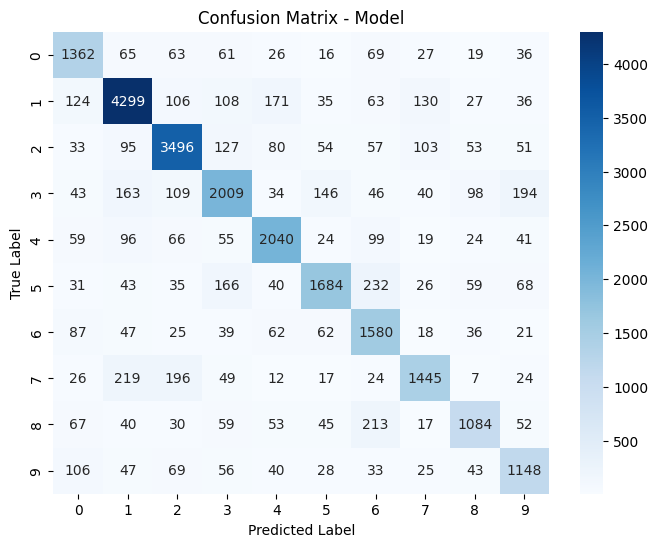

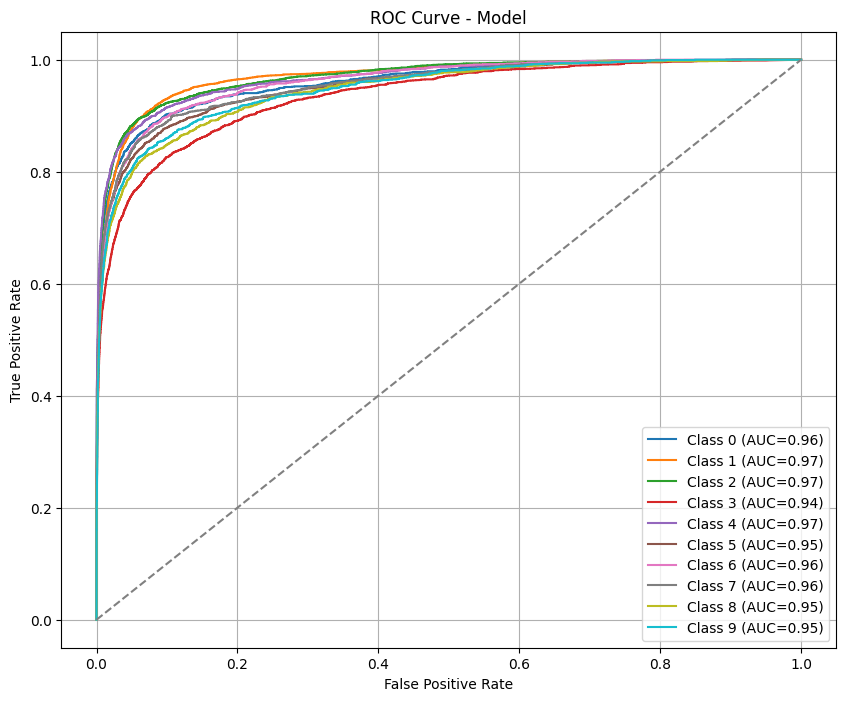

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━

In [ ]:
evaluate_mlp_model(mlp_model, ds_test)
quick_predict_evaluate(mlp_model, ds_test, model_name="MLP")

# Evaluasi Model MLP dan CNN pada Dataset SVHN

## 1. Hasil Evaluasi

### MLP

- **Test Accuracy**: 77.39%
- **Precision (macro)**: 0.7578
- **Recall (macro)**: 0.7566
- **F1 Score (macro)**: 0.7554
- **AUC Score (macro)**: 0.9567

#### Classification Report (MLP)

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.70      | 0.78   | 0.74     | 1744    |
| 1     | 0.84      | 0.84   | 0.84     | 5099    |
| 2     | 0.83      | 0.84   | 0.84     | 4149    |
| 3     | 0.74      | 0.70   | 0.72     | 2882    |
| 4     | 0.80      | 0.81   | 0.80     | 2523    |
| 5     | 0.80      | 0.71   | 0.75     | 2384    |
| 6     | 0.65      | 0.80   | 0.72     | 1977    |
| 7     | 0.78      | 0.72   | 0.75     | 2019    |
| 8     | 0.75      | 0.65   | 0.70     | 1660    |
| 9     | 0.69      | 0.72   | 0.70     | 1595    |

---

### CNN

- **Test Accuracy**: 88.35%
- **Precision (macro)**: 0.8701
- **Recall (macro)**: 0.8774
- **F1 Score (macro)**: 0.8723
- **AUC Score (macro)**: 0.9838

---

## 2. Perbandingan Metrik Evaluasi

| Metric           | MLP    | CNN    |
|------------------|--------|--------|
| Akurasi          | 0.7739 | 0.8835 |
| Presisi          | 0.7578 | 0.8701 |
| Recall           | 0.7566 | 0.8774 |
| F1 Score         | 0.7554 | 0.8723 |
| AUC (Macro)      | 0.9567 | 0.9838 |

---

## 3. Penjelasan Metrik Evaluasi

### Akurasi (Accuracy)

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

Akurasi mengukur seberapa banyak prediksi model yang benar dari seluruh data.  
CNN menunjukkan akurasi lebih tinggi (88.35%) dibandingkan MLP (77.39%), artinya CNN lebih mampu mengklasifikasikan gambar dengan tepat.

---

### Presisi (Precision)

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

Presisi menunjukkan proporsi prediksi positif yang benar.  
CNN lebih unggul dengan nilai presisi 87.01%, dibandingkan dengan MLP yang mencetak 75.78%.

---

### Recall (Sensitivity)

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

Recall mengukur seberapa baik model mendeteksi semua instance yang relevan.  
CNN memperoleh recall sebesar 87.74%, sedangkan MLP hanya 75.66%.

---

### F1 Score

$$
F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

F1 Score adalah rata-rata harmonik antara precision dan recall, mencerminkan keseimbangan antara keduanya.  
CNN mencatat nilai F1 Score tertinggi (87.23%) dibandingkan MLP (75.54%).

---

### AUC (Area Under Curve)

AUC menunjukkan seberapa baik model membedakan antar kelas.  
Nilai AUC yang tinggi (dekat 1) menunjukkan performa klasifikasi yang sangat baik.  
CNN unggul dengan AUC 0.9838 dibandingkan MLP yang meraih 0.9567.

---

## 4. Kesimpulan

Model CNN secara konsisten menunjukkan performa yang lebih baik dibandingkan MLP pada semua metrik evaluasi, termasuk akurasi, presisi, recall, F1 score, dan AUC.

- CNN memiliki kemampuan lebih kuat dalam memahami pola spasial dari data gambar.
- MLP cocok sebagai baseline, namun kurang ideal untuk data visual kompleks seperti SVHN.

